# IPython Notebook

This is an IPython Notebook, an online scientific notebook which combines, text, data, images, and programming. It is amazing, and could be a fantastic way to do and communicate advanced LCA work.

* [Documentation](http://ipython.org/ipython-doc/dev/interactive/htmlnotebook.html)
* [Very long awesomeness](https://www.youtube.com/watch?v=2G5YTlheCbw)
* [Sharable awesomeness](http://nbviewer.ipython.org/)
* [Just plain amazing awesomeness](http://nbviewer.ipython.org/url/epi.whoi.edu/esr/GIS_GRASS-R_Example.ipynb)
* [Gallery of awesomeness](https://github.com/ipython/ipython/wiki/A-gallery-of-interesting-IPython-Notebooks)
* [Hacker News discussion](http://news.ycombinator.com/item?id=4909070)

You can also download the [ipython file](/examples/new-pedigree-matrix.ipynb) and run it yourself.

## Pedigree matrix factor calculations

In [1]:
from brightway2 import *
from pedigree_matrix import *
import numpy as np
db = Database("ecoinvent 2.2")
ei_data = db.load()

We can use the [pedigree matrix](https://bitbucket.org/cmutel/pedigree-matrix) library for the calculations.

In [2]:
sigmas_1_tech, sigmas_1_bio, sigmas_2_tech, sigmas_2_bio = [], [], [], []

for ds in ei_data.values():
    for exc in ds["exchanges"]:
        try:
            pm = PedigreeMatrix()
            pm.from_string(exc["comment"])
            if exc["input"][0] == "biosphere":
                sigmas_1_bio.append(pm.calculate())
                pm.version = 2
                sigmas_2_bio.append(pm.calculate())
            else:
                sigmas_1_tech.append(pm.calculate())
                pm.version = 2
                sigmas_2_tech.append(pm.calculate())

        except:
            pass

sigmas_1_tech, sigmas_2_tech = np.array(sigmas_1_tech), np.array(sigmas_2_tech)
sigmas_1_bio, sigmas_2_bio = np.array(sigmas_1_bio), np.array(sigmas_2_bio)

Let's learn a little about our results

In [3]:
print "Technosphere exchanges: %s. Biosphere exchanges: %s" % (sigmas_1_tech.shape[0], sigmas_1_bio.shape[0])
print "For technosphere:"
print "New version has more uncertainty (percentage)"
print (sigmas_2_tech > sigmas_1_tech).sum() / float(sigmas_1_tech.shape[0])
print "Uncertainty didn't change (percentage)"
print (sigmas_2_tech == sigmas_1_tech).sum() / float(sigmas_1_tech.shape[0])
print "For biosphere:"
print "New version has more uncertainty (percentage)"
print (sigmas_2_bio > sigmas_1_bio).sum() / float(sigmas_1_bio.shape[0])
print "Uncertainty didn't change (percentage)"
print (sigmas_2_bio == sigmas_1_bio).sum() / float(sigmas_1_bio.shape[0])

Technosphere exchanges: 24426. Biosphere exchanges: 28009
For technosphere:
New version has more uncertainty (percentage)
0.855604683534
Uncertainty didn't change (percentage)
0.0339801850487
For biosphere:
New version has more uncertainty (percentage)
0.893320004284
Uncertainty didn't change (percentage)
0.0182084330037


Let's transform to square of geometric standard deviation (it sounds, and is crazy, but the kids love it...)

In [4]:
sigmas_1_tech, sigmas_2_tech = np.exp(sigmas_1_tech) ** 2, np.exp(sigmas_2_tech) ** 2
sigmas_1_bio, sigmas_2_bio = np.exp(sigmas_1_bio) ** 2, np.exp(sigmas_2_bio) ** 2

## Histograms

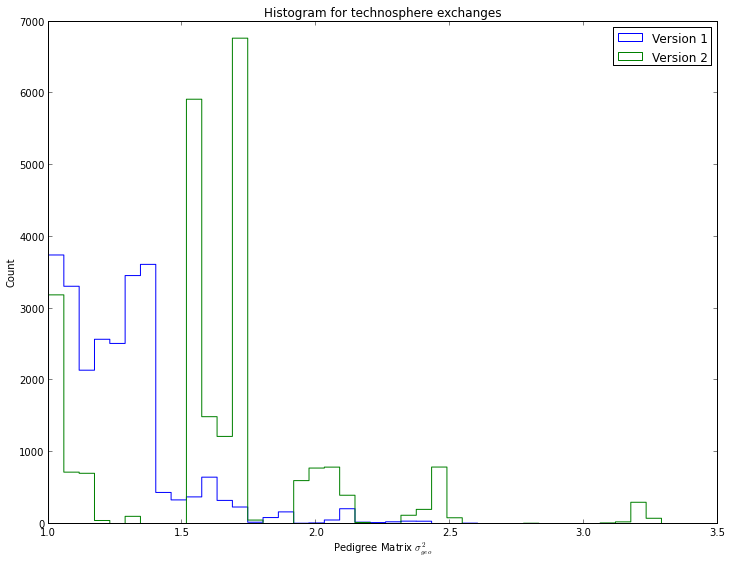

In [5]:
clf()
figure(figsize=(12,9), dpi=600)
hist([sigmas_1_tech, sigmas_2_tech], histtype="step", bins=40, label=["Version 1", "Version 2"])
legend()
xlabel(r"Pedigree Matrix $\sigma_{geo}^{2}$")
ylabel("Count")
title("Histogram for technosphere exchanges")

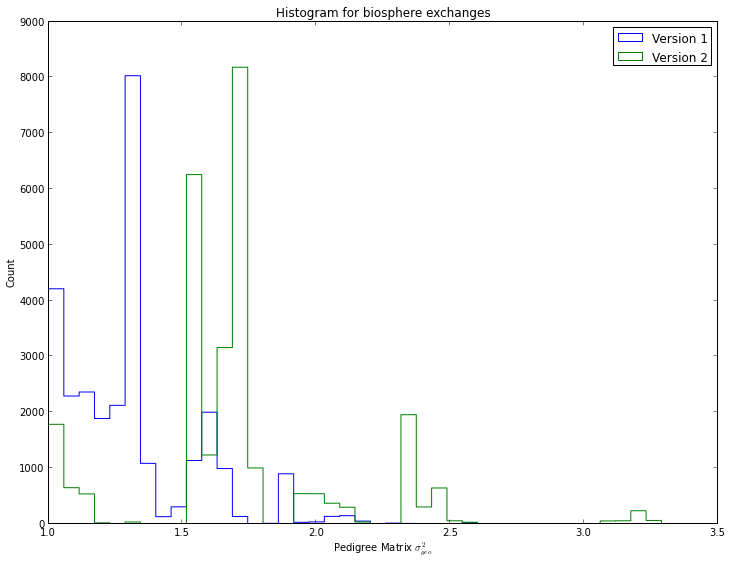

In [8]:
clf()
figure(figsize=(12,9), dpi=600)
hist([sigmas_1_bio, sigmas_2_bio], histtype="step", bins=40, label=["Version 1", "Version 2"])
legend()
xlabel(r"Pedigree Matrix $\sigma_{geo}^{2}$")
ylabel("Count")
title("Histogram for biosphere exchanges")

Histogram for the difference (ratio) in all exchanges (biosphere and technosphere)

In [29]:
all_sigmas_1 = np.hstack((sigmas_1_bio, sigmas_1_tech))
all_sigmas_2 = np.hstack((sigmas_2_bio, sigmas_2_tech))
print "New version has more uncertainty (percentage)"
print (all_sigmas_2 > all_sigmas_1).sum() / float(all_sigmas_1.shape[0])
print "Uncertainty didn't change (percentage)"
print (all_sigmas_2 == all_sigmas_1).sum() / float(all_sigmas_1.shape[0])

New version has more uncertainty (percentage)
0.875750929723
Uncertainty didn't change (percentage)
0.0255554496043


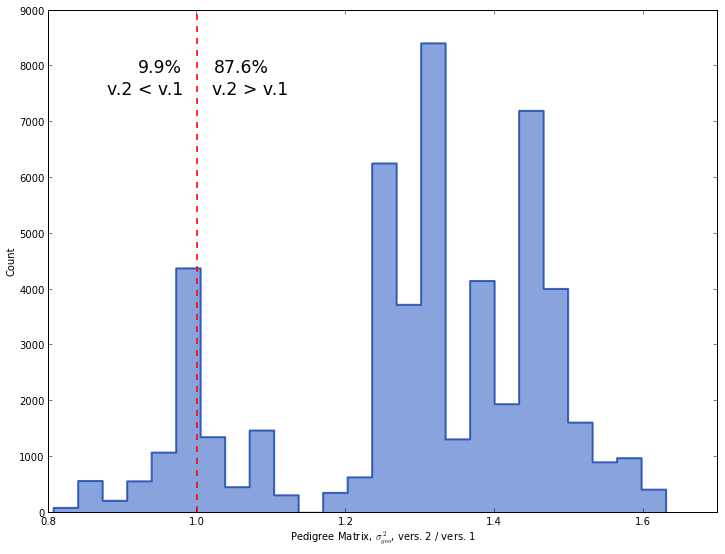

In [59]:
clf()
figure(figsize=(12,9), dpi=600)
hist(all_sigmas_2 / all_sigmas_1, histtype="stepfilled", bins=25, lw=2, ec="#1240ab", fc="#6c8cd5", alpha=0.8)
plot((1, 1), (0, 9000), 'r--', lw=2, alpha=0.8)
text(
    1.06, 8000., "87.6%",
    horizontalalignment="center",
    verticalalignment="center",
    size="xx-large"
)
text(
    1.07, 7600., "v.2 > v.1",
    horizontalalignment="center",
    verticalalignment="center",
    size="xx-large"
)
text(
    0.95, 8000., "9.9%",
    horizontalalignment="center",
    verticalalignment="center",
    size="xx-large"
)
text(
    0.93, 7600., "v.2 < v.1",
    horizontalalignment="center",
    verticalalignment="center",
    size="xx-large"
)
xlabel(r"Pedigree Matrix, $\sigma_{geo}^{2}$, vers. 2 / vers. 1")
ylabel("Count")
savefig("histogram-ratio.png", dpi=600)

## Density map for technosphere

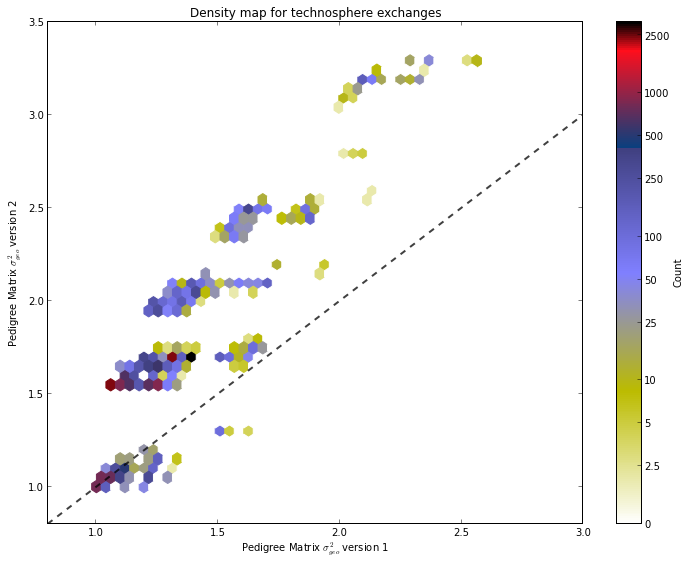

In [7]:
clf()
figure(figsize=(12,9), dpi=600)
limits = [0.8, 3.5]
plot(limits, limits, 'k--', alpha=0.75, lw=2)
hexbin(sigmas_1_tech, sigmas_2_tech, bins='log', cmap=cm.gist_stern_r, gridsize=40)
# title("With a log color scale")
xlabel(r"Pedigree Matrix $\sigma_{geo}^{2}$ version 1")
ylabel(r"Pedigree Matrix $\sigma_{geo}^{2}$ version 2")
cb = colorbar()
cb.set_label('Count')
cb.set_ticks([0, 0.4, 0.7, 1, 1.4, 1.7, 2, 2.4, 2.7, 3, 3.4, 3.7])
cb.set_ticklabels([0, 2.5, 5, 10, 25, 50, 100, 250, 500, 1000, 2500, 5000])
xlim((0.8, 3))
ylim(limits)
title("Density map for technosphere exchanges")
savefig("pm-hexbin-technosphere.png", dpi=600)

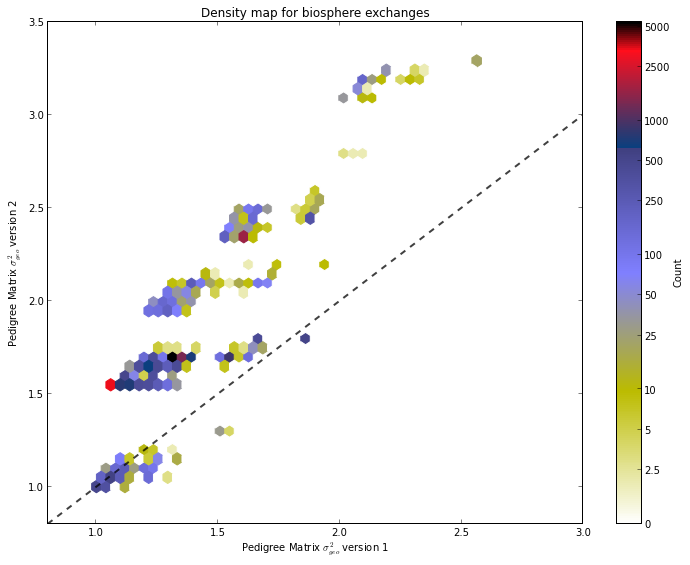

In [10]:
clf()
figure(figsize=(12,9), dpi=600)
limits = [0.8, 3.5]
plot(limits, limits, 'k--', alpha=0.75, lw=2)
hexbin(sigmas_1_bio, sigmas_2_bio, bins='log', cmap=cm.gist_stern_r, gridsize=40)
# title("With a log color scale")
xlabel(r"Pedigree Matrix $\sigma_{geo}^{2}$ version 1")
ylabel(r"Pedigree Matrix $\sigma_{geo}^{2}$ version 2")
cb = colorbar()
cb.set_label('Count')
cb.set_ticks([0, 0.4, 0.7, 1, 1.4, 1.7, 2, 2.4, 2.7, 3, 3.4, 3.7])
cb.set_ticklabels([0, 2.5, 5, 10, 25, 50, 100, 250, 500, 1000, 2500, 5000])
xlim((0.8, 3))
ylim(limits)
title("Density map for biosphere exchanges")
savefig("pm-hexbin-biosphere.png", dpi=600)

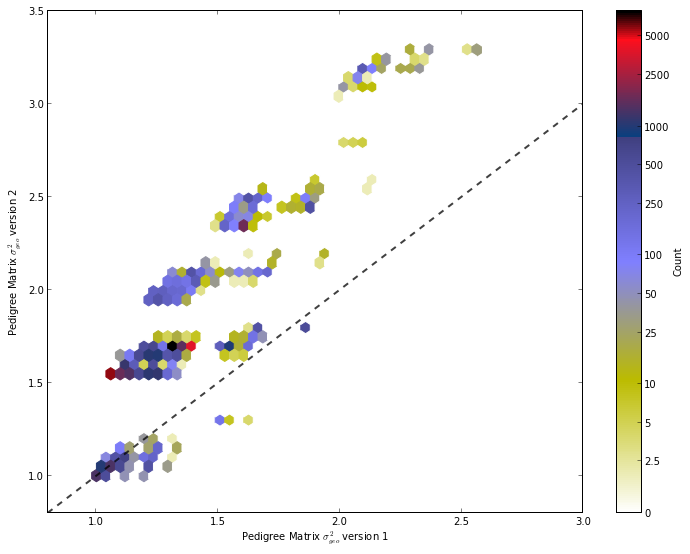

In [25]:
clf()
figure(figsize=(12,9), dpi=600)
limits = [0.8, 3.5]
plot(limits, limits, 'k--', alpha=0.75, lw=2)
hexbin(all_sigmas_1, all_sigmas_2, bins='log', cmap=cm.gist_stern_r, gridsize=40)
# title("With a log color scale")
xlabel(r"Pedigree Matrix $\sigma_{geo}^{2}$ version 1")
ylabel(r"Pedigree Matrix $\sigma_{geo}^{2}$ version 2")
cb = colorbar()
cb.set_label('Count')
cb.set_ticks([0, 0.4, 0.7, 1, 1.4, 1.7, 2, 2.4, 2.7, 3, 3.4, 3.7])
cb.set_ticklabels([0, 2.5, 5, 10, 25, 50, 100, 250, 500, 1000, 2500, 5000])
xlim((0.8, 3))
ylim(limits)
savefig("pm-hexbin.png", dpi=600)

## Let's show which Pedigree Matrix values are used most often

In [20]:
labels = sorted(PedigreeMatrix().labels)

In [21]:
counts = np.zeros((6, 5)).astype(int)

row_map = {k: i for i, k in enumerate(labels)}

for ds in ei_data.values():
    for exc in ds["exchanges"]:
        try:
            pm = PedigreeMatrix()
            pm.from_string(exc["comment"])
            for key, value in pm.factors.iteritems():
                counts[row_map[key], value -1] += 1
        except:
            pass

counts

array([[ 9599,  8059,  9617,  6568, 18592],
       [41502,    11,  5833,  4261,   828],
       [36052,  3465, 10645,     0,  2273],
       [ 9426, 15814,  7909, 16137,  3149],
       [18482,  1348,  8248,  4970, 19387],
       [34613,  7597,  6254,  2364,  1607]])

Calculate difference between new and old factors (the values are log-scaled, but we do in percentage anyway...)

In [22]:
from pedigree_matrix.data import version_1, version_2

difference = np.zeros((6,5))

for label in labels:
    row = row_map[label]
    new = np.array(version_2[label])
    old = np.array(version_1[label])
    difference[row, :] = (new - old) / old

# In percentage
difference = difference * 100
    
print difference

[[  0.           0.98039216  -0.95238095  -1.81818182 -10.        ]
 [  0.          18.          37.5         38.66666667  40.        ]
 [  0.           2.97029703   5.88235294   8.82352941   0.90909091]
 [  0.          46.66666667  46.36363636  40.83333333  12.66666667]
 [  0.          -1.96078431  -4.76190476  -9.09090909 -16.66666667]
 [  0.           0.           0.          -0.83333333 -14.        ]]


Shorten some labels

In [23]:
labels[1] = "technol. correl."
labels[2] = "geo. correl."
labels[4] = "sample size*"
labels[5] = "temp. correl."

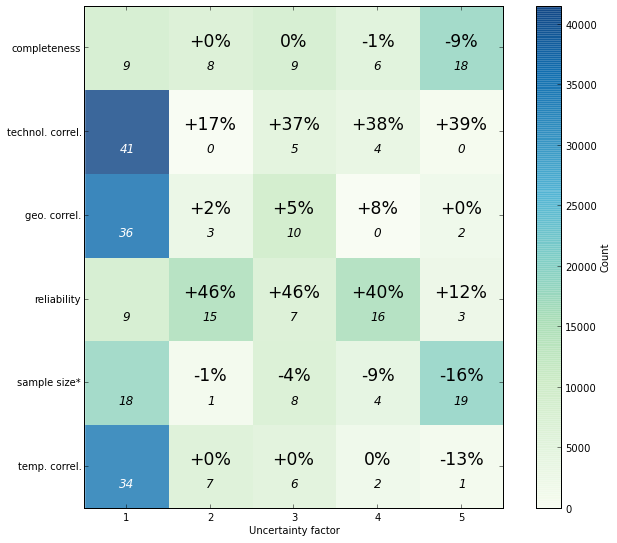

In [24]:
clf()
figure(figsize=(12,9), dpi=600)
imshow(counts, cmap=cm.GnBu, interpolation='none', alpha=0.8)
cb = colorbar()
cb.set_label("Count")
xticks(range(5), range(1, 6))
xlabel("Uncertainty factor")
yticks(range(6), labels)
# Add text labels for percentage change
for x in range(1, 5):
    for y in range(6):
        s = "%s%s%%" % ("+" if difference[y, x] >= 0 else "", int(difference[y, x]))
        if s == "+0":
            s = "0"
        text(x, y - 0.1, s,
            horizontalalignment="center",
            verticalalignment="center",
            size="xx-large")
for x in range(5):
    for y in range(6):
        c = "%s" % int(counts[y, x] / 1000)
        color = "black"
        if x == 0 and y in (1,2, 5):
            color="white"
        text(x, y + 0.2, c,
            horizontalalignment="center",
            verticalalignment="center",
            size="large",
            style="italic",
            color=color)
savefig("pm-matrix.png", dpi=600)


## Graph of "stretching"

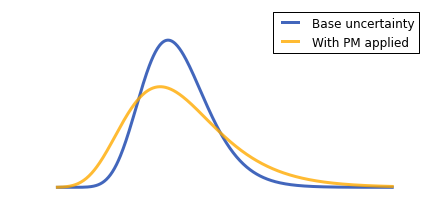

In [58]:
from scipy import stats
xs = np.linspace(0.3, 2.3, 500)
ys = stats.lognorm.pdf(xs, 0.2, scale=1)
clf()
figure(figsize=(7.5, 3.5))
plot(xs, ys, lw=3, color="#1240ab", label="Base uncertainty", alpha=0.8)
ys = stats.lognorm.pdf(xs, 0.3, scale=1)
plot(xs, ys, lw=3, color="#ffaa00", label="With PM applied", alpha=0.8)
box(False)
xticks([])
yticks([])
ylim(-0.2, ylim()[1])
legend(loc="upper right")
savefig("stretched.png", dpi=1200)